In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', 0) #To display entire text content of a column
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.metrics import precision_score, recall_score, f1_score
import timeit
import os
import pickle
import joblib as joblib
from sklearn.ensemble import RandomForestClassifier

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anuroop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
os.chdir('D:\capstone_data\processed_csv\master_data_clean_sent140_cmplnts_mixed')

In [4]:
#Read csv
tweet_complaints_df =  pd.read_csv('sent140_cmplnts_50k_clean.csv')

In [5]:
#verify
display(tweet_complaints_df.shape)
display(tweet_complaints_df.tail(2))

(50498, 2)

,label,clean_text
50496,1,trouble in iran i see hmm iran iran so far away
50497,1,reading the tweets coming out of iran the whole thing is terrifying and incredibly sad


# Bag of Words model

In [6]:
#Features
X = tweet_complaints_df['clean_text']
display(X.head(1))
#Target
y = tweet_complaints_df['label']
display(y.head(1))

0     lol  damm u make commision when she wins  nicee  btw  what do u play when ure there 
Name: clean_text, dtype: object

0    0
Name: label, dtype: int64

In [7]:
#train test split before vectorization to avoid information being carried over to test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, 
                                                    random_state = 7)

In [8]:
#Verify
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(45448,)

(5050,)

(45448,)

(5050,)

In [9]:
#Create a stemmer object
stemmer = nltk.PorterStemmer()
ENGLISH_STOP_WORDS = stopwords.words('english')

In [10]:
#Custom tokenizer to stem and remove stopwords
def my_tokenizer(sentence):
   # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [11]:
#Instantiate using custom tokenizer and only words that appear in atleast 1% of documents
bagofwords = CountVectorizer(tokenizer = my_tokenizer, min_df = 0.01)

#Fit vectorizer on X_train 
bagofwords.fit(X_train)

#Transform
X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

#Check number of features in train and test
display(X_train_transformed.shape)
display(X_test_transformed.shape)

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(45448, 642)

(5050, 642)

We have 642 features when transformed with bag of words model

In [27]:
#Create a df of transformed data
X_train_transformed_df = pd.DataFrame(columns = bagofwords.get_feature_names(),
                                     data = X_train_transformed.toarray())
display(X_train_transformed_df.head(1))

X_test_transformed_df = pd.DataFrame(columns = bagofwords.get_feature_names(),
                                     data = X_test_transformed.toarray())
display(X_test_transformed_df.head(1))


,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,worth,would,write,wrong,x,xx,ye,year,yet,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,worth,would,write,wrong,x,xx,ye,year,yet,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [28]:
#Top 20 most frequent words
top_20_words = X_train_transformed_df.sum(axis = 0).sort_values(ascending = False)[:19]

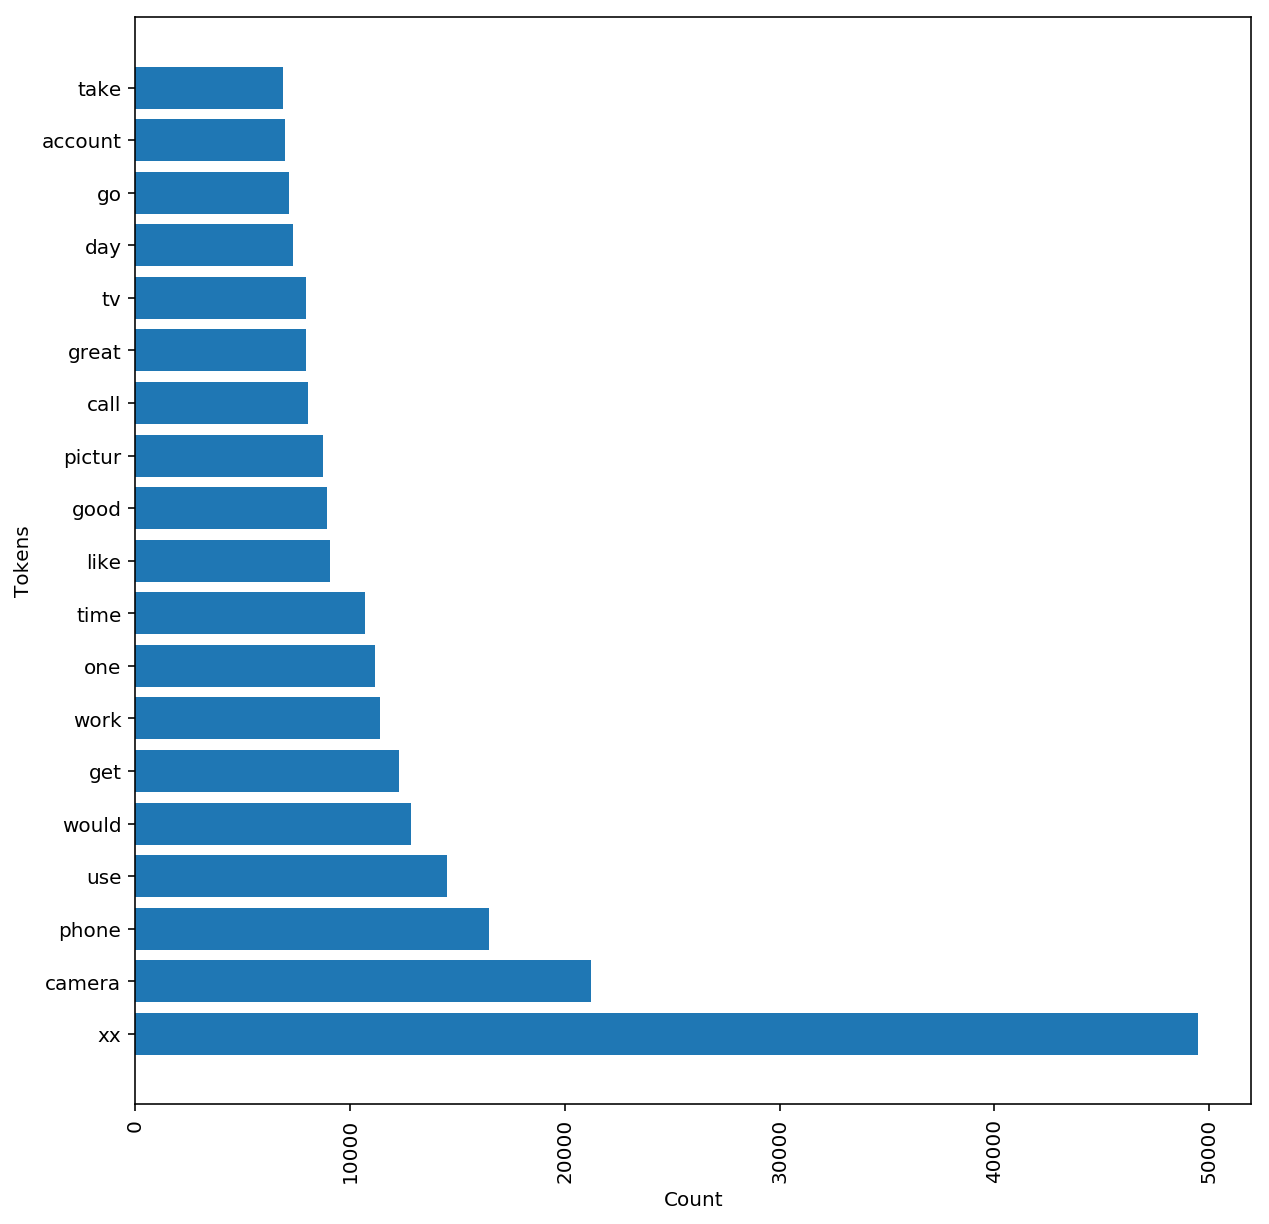

In [29]:
#Visualize vectorized data
plt.figure(figsize =(10,10))
plt.barh(top_20_words.index, top_20_words.values)
plt.xlabel("Count")
plt.xticks(rotation = 90)
#plt.xlim(100,35000)
plt.ylabel("Tokens")
plt.show()

# First fit - Logistic Regression

In [30]:
# Fit a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_transformed_df, y_train)

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [31]:
#Accuracy
print(f"The accuracy of unoptimized Log reg model on train set is: {round(log_reg.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized Log reg model on test set is: {round(log_reg.score(X_test_transformed_df,y_test),2)}")

The accuracy of unoptimized Log reg model on train set is: 0.79
The accuracy of unoptimized Log reg model on train set is: 0.78


Good accuracies from unoptimized logistic regression model. **Low bias and low variance**.


In [32]:
#Create a df for feature coefficients
coef_df = pd.DataFrame(data = log_reg.coef_, columns = X_train_transformed_df.columns, 
                       index = ['coef'])
coef_df.tail()


,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,worth,would,write,wrong,x,xx,ye,year,yet,zoom
coef,0.028793,0.397257,-0.001054,-0.02814,0.571584,0.260719,0.02294,0.047613,-0.41544,-0.802393,...,0.093005,0.175701,-0.146745,0.469532,-0.195342,0.875608,-0.621087,0.046269,-0.271433,0.015286


In [33]:
#Top 25 words 
coef_df_top_25 = coef_df.sort_values(by ='coef', axis = 1, ascending = False).iloc[:,:24]
coef_df_top_25

,sad,debt,terribl,mortgag,worst,loan,refus,wast,poor,owe,...,collect,disappoint,fail,miss,sorri,disput,die,lost,agenc,unfortun
coef,2.626639,2.259019,2.167778,2.114697,1.834351,1.698911,1.675781,1.59524,1.59443,1.509702,...,1.260266,1.213862,1.201118,1.173114,1.164019,1.148848,1.102819,1.054475,0.963373,0.945893


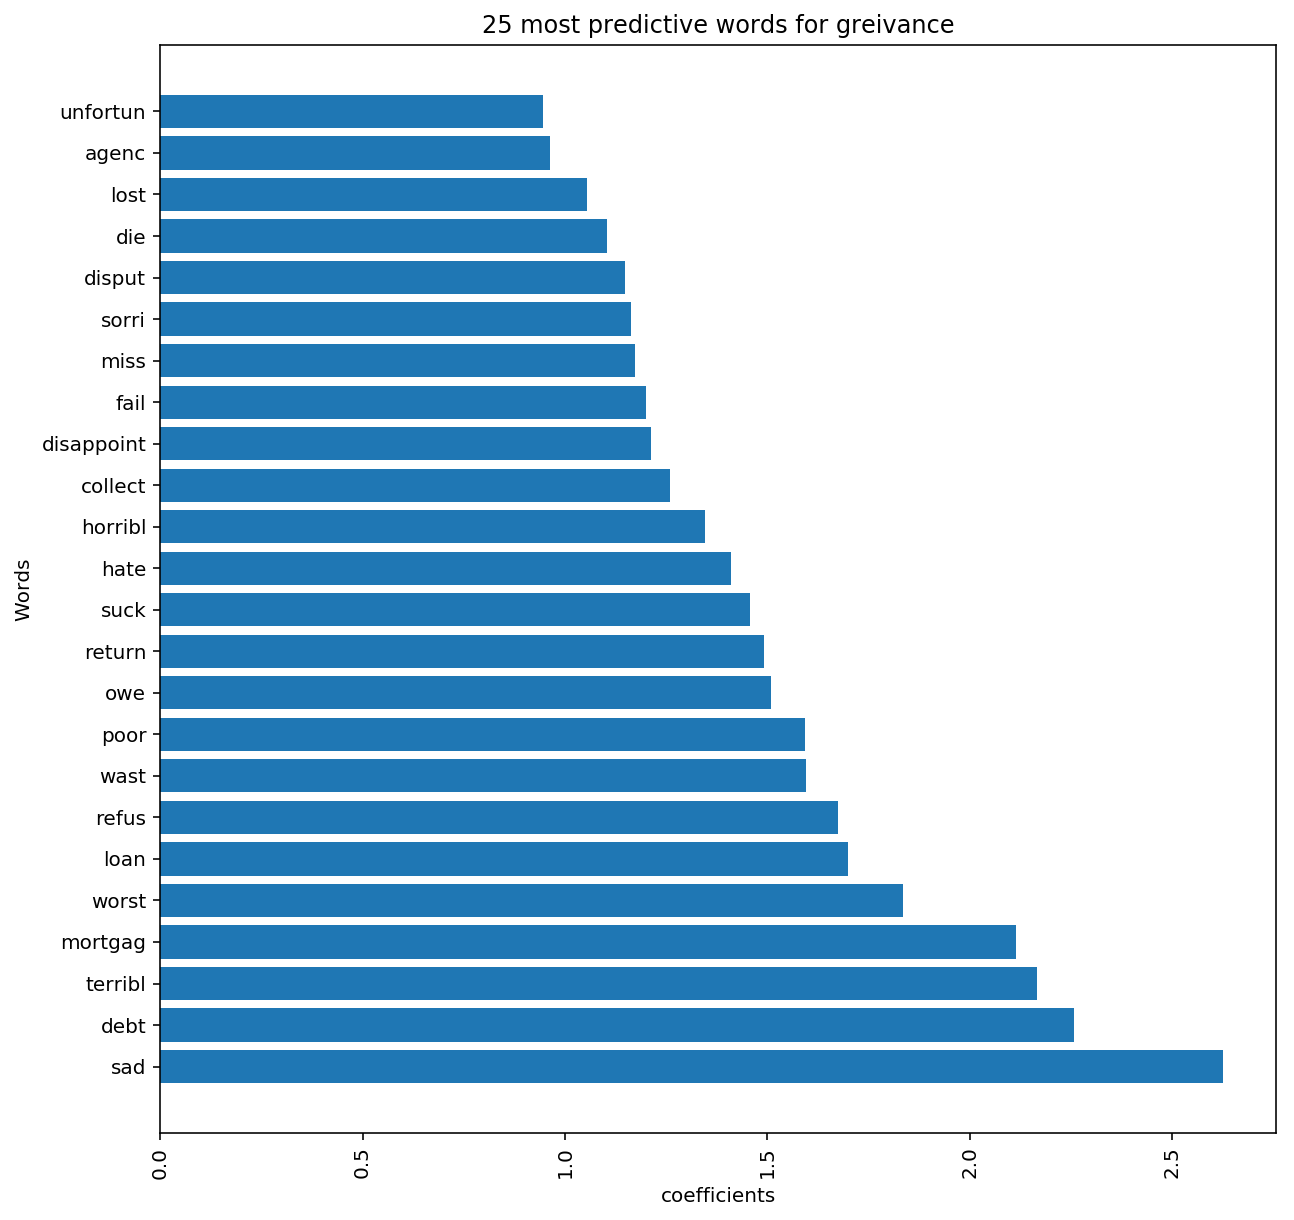

In [34]:
#Visualize top 25 words
plt.figure(figsize =(10,10))
plt.barh(coef_df_top_25.loc['coef'].index, coef_df_top_25.loc['coef'].values)
plt.xlabel("coefficients")
plt.xticks(rotation = 90)
plt.ylabel("Words")
plt.title('25 most predictive words for greivance')
plt.show()

Most words are negative but **certain words represent financial products** like Mortgage, debt, loan. This is due to the fact that our model was trained on a dataset that comprises of complaints against financial products as one form of greivance. This datatset comprised of only complaints and hence did not contribute towards 0 class. Consequently, certain frequent words from the dataset tend to be more indicative of class 1 and have high coefficient values. This couldlead to model mdoel being biased towards certain products and may not be able generalize. To adress this problem, we have to **explore original features of datasets and find a way to extract product names** which will then be eliminated by **creating a product specific filter in our custom tokenizer.** Sentiment 140 dataset does not need to revisited as it comprises of generic tweets rather than text about a targeted product.
However it must be noted that **same tokenizer cannot be used for the 2nd part of project i.e. Topic modelling** because then the model will fail to model topics for filtered products.

# Extract product names from consumer_complaints

In [56]:
#Read from original csv
consumer_complaints =  pd.read_csv('D:\capstone_data\Consumer_Complaints.csv', na_values = None)
consumer_complaints.tail(1)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
903982,8/19/2016,Debt collection,Payday loan,Cont'd attempts collect debt not owed,Debt is not mine,"I had a debit that was included in my chapter XXXX BK, almost two years letter this item showed on my credit reports under collection status for Midwest Recovery Systems. This dropped my credit score XXXX points. I called them and they said their client had n't informed them that it was included in BK, but the damage had already been done. It took them 30 days to remove this incorrectly put item on my credit reports. Its still showing up on my XXXX. I thought this was against the law for them to do that since I am protected by BK laws. They should be fined for this. I should sue.",Company believes it acted appropriately as authorized by contract or law,Midwest Recovery Systems,FL,336XX,NaN,Consent provided,Web,8/19/2016,Closed with explanation,Yes,Yes,2073214


In [58]:
#filtering only rows where 'Consumer complaint narrative' is not null
#because we will work with observations with narrtives only
consumer_complaints_narrative_notnull = consumer_complaints[
    consumer_complaints['Consumer complaint narrative'].isna() == False]

It seems to very straightforward, we can just extract unique values of feature `Product`

In [59]:
#Product unique values
fin_prods = consumer_complaints_narrative_notnull['Product'].unique()
fin_prods

array(['Credit reporting', 'Consumer Loan', 'Debt collection', 'Mortgage',
       'Credit card', 'Other financial service',
       'Bank account or service', 'Student loan', 'Money transfers',
       'Payday loan', 'Prepaid card', 'Virtual currency',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card', 'Checking or savings account',
       'Payday loan, title loan, or personal loan',
       'Vehicle loan or lease',
       'Money transfer, virtual currency, or money service'], dtype=object)

In [65]:
#Product names and corresponding fraction of complaints for each
consumer_complaints_narrative_notnull['Product'].value_counts() \
/len(consumer_complaints_narrative_notnull)

Debt collection                                                                 0.239611
Mortgage                                                                        0.182937
Credit reporting                                                                0.157984
Credit card                                                                     0.094224
Bank account or service                                                         0.074451
Credit reporting, credit repair services, or other personal consumer reports    0.073366
Student loan                                                                    0.066530
Consumer Loan                                                                   0.047377
Credit card or prepaid card                                                     0.016778
Checking or savings account                                                     0.010712
Payday loan                                                                     0.008741
Money transfers      

In [62]:
#Cumulative sum of fractions
(consumer_complaints_narrative_notnull['Product'].value_counts()
 /len(consumer_complaints_narrative_notnull)).cumsum()

Debt collection                                                                 0.239611
Mortgage                                                                        0.422548
Credit reporting                                                                0.580532
Credit card                                                                     0.674756
Bank account or service                                                         0.749207
Credit reporting, credit repair services, or other personal consumer reports    0.822573
Student loan                                                                    0.889103
Consumer Loan                                                                   0.936480
Credit card or prepaid card                                                     0.953258
Checking or savings account                                                     0.963970
Payday loan                                                                     0.972711
Money transfers      

It can be seen that around  93% of complaints narratives have been covered in the top 8 categories, upto `Consumer loan`. Hence we will create a list that accounts for top 8 products. Product names with more than 2 words will be included as 2 separate words as we have already seen that 'debt and 'collection' appeared separately in our list of 20 most predictive words. Certain generic words in product names like student, consumer etc. do not have to be included, just 'loan' should suffice.

In [9]:
filter_ls = ['debt',
 'collection',
 'collections',
 'mortgage',
 'credit',
 'report',
 'reports',
 'bank',
 'loan']

As we saw above, the word that appeared most frequently after vectorization was **'xx'**. This word also comes from consumer complaints as sensitve information in narrative is coded as 'XXXX..'. Since we had already implemented trimming word when letters repeat more than twice, it's transformed to 'xx'. Since this word has no associated meaning, this **will also be eliminated by including in filter_ls**.

In [10]:
#Adding 'xx' to filter_ls
filter_ls.append('xx')

In [11]:
#Verify
filter_ls

['debt',
 'collection',
 'collections',
 'mortgage',
 'credit',
 'report',
 'reports',
 'bank',
 'loan',
 'xx']

# Modify tokenizer and refit model

In [12]:
#Add filter_ls in condtional 
def cust_tokenizer_prods_rmvd(sentence):
   # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        #Include filter_ls
        if (not word in ENGLISH_STOP_WORDS) and (not word in filter_ls) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [13]:
#Verify
sentence = 'Bought a xx Camera on loan Would also like to buy phone on credit I hope collection folks are gonna go easy on me Also mortgage is killin me brah'
#Did not include any punctuations as they will be taken care of before tokenizer
cust_tokenizer_prods_rmvd(sentence)

['bought',
 'camera',
 'would',
 'also',
 'like',
 'buy',
 'phone',
 'I',
 'hope',
 'folk',
 'gonna',
 'go',
 'easi',
 'also',
 'killin',
 'brah']

## BagofWords with n_gram
Let's refit bagofwords with with bigrams & trigrams as well to see if it helps improves performamce.

In [14]:
#Instantiate using cust_tokenizer_prods_rmvd and only words that appear in atleast 1% of documents
bagofwords = CountVectorizer(tokenizer = cust_tokenizer_prods_rmvd, 
                             min_df = 0.01, ngram_range =(1,3))

#Fit vectorizer on X_train 
bagofwords.fit(X_train)


#Transform
X_train_transformed = bagofwords.transform(X_train)
X_test_transformed = bagofwords.transform(X_test)

#Check number of features in train and test
display(X_train_transformed.shape)
display(X_test_transformed.shape)

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\feature_extraction\text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(45448, 656)

(5050, 656)

Number of features increaseed slightly, 656, than earlier, 642, which was expected because we used a n_gram range of upto 3.

In [15]:
#Create a function for creating train and test tarnsformed df
#and visualizing n frequent words
def return_trnsfrmddf_visualize_words(X_train_transformed, X_test_transformed, fit,n_words):
    X_train_transformed_df = pd.DataFrame(columns = fit.get_feature_names(),
                                         data = X_train_transformed.toarray())
    X_test_transformed_df = pd.DataFrame(columns = fit.get_feature_names(),
                                         data = X_test_transformed.toarray())
    #Top 20 most frequent words
    top_words = X_train_transformed_df.sum(axis = 0).sort_values(ascending = False)[:n_words - 1]

    #Visualize vectorized data
    plt.figure(figsize =(10,10))
    plt.barh(top_words.index, top_words.values)
    plt.xlabel("Count")
    plt.xticks(rotation = 90)
    plt.ylabel("Tokens")
    plt.show()
    #return dfs
    return X_train_transformed_df, X_test_transformed_df
    




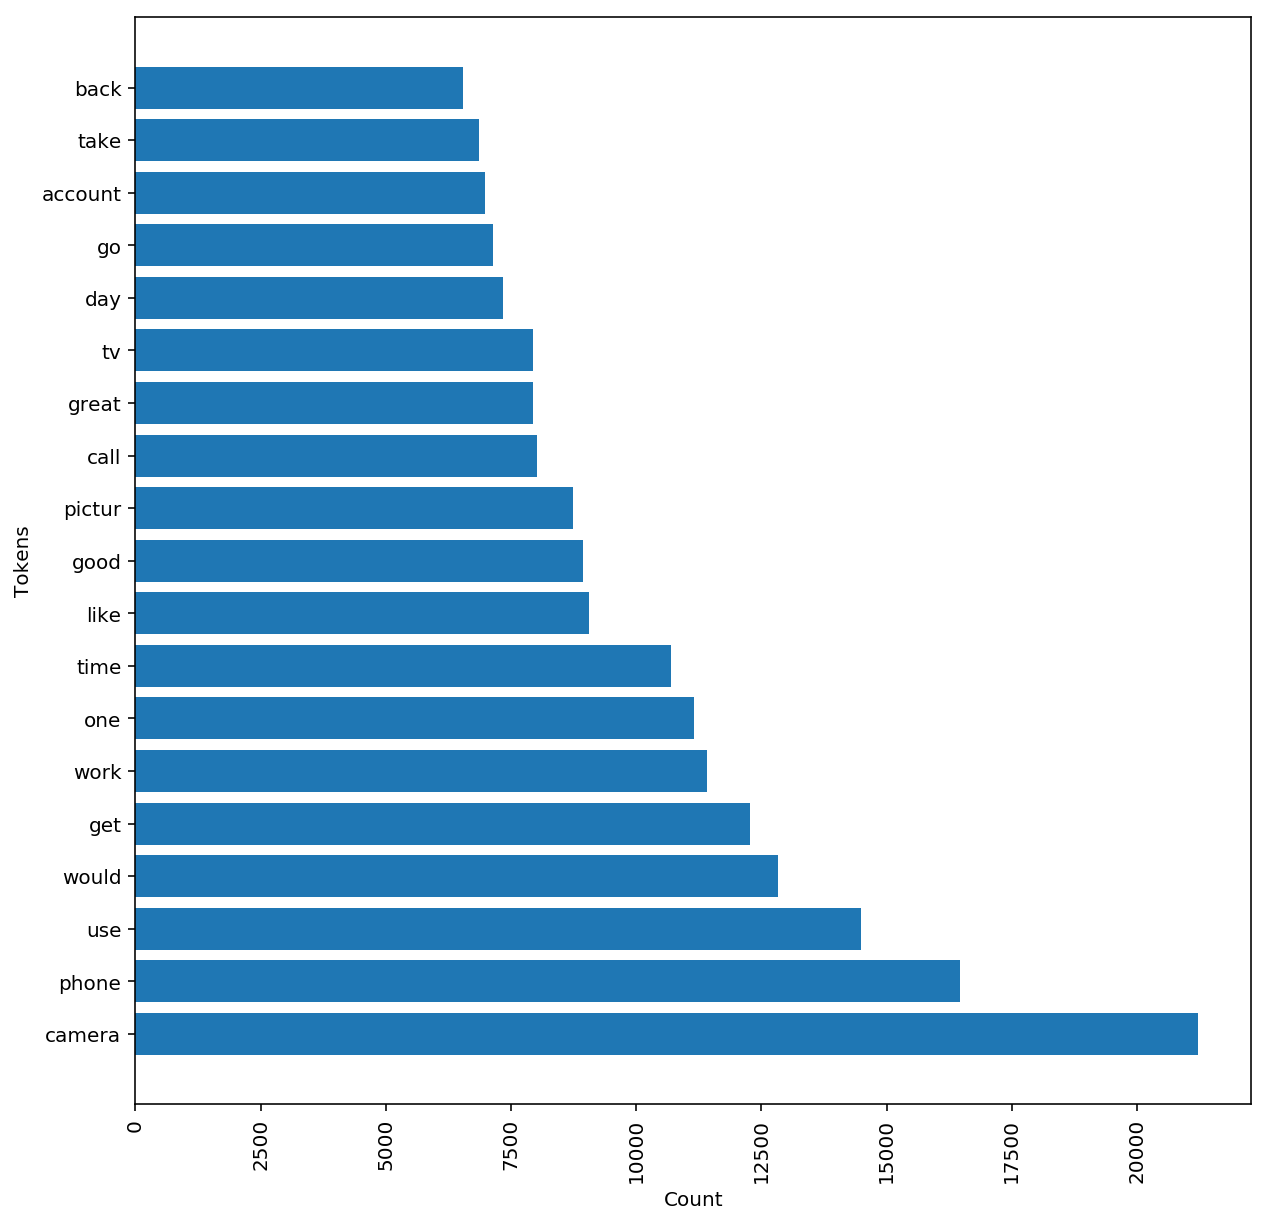

In [16]:
#Verify functions
X_train_transformed_df, X_test_transformed_df = return_trnsfrmddf_visualize_words(
    X_train_transformed, X_test_transformed, bagofwords,20)

In [17]:
#Verify dfs returned by function
display(X_train_transformed_df.head(1))
display(X_train_transformed_df.shape)
display(X_test_transformed_df.head(1))
display(X_test_transformed_df.shape)

,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,would recommend,write,wrong,x,ye,year,year ago,year old,yet,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(45448, 656)

,abl,absolut,accept,access,account,action,activ,actual,ad,add,...,would recommend,write,wrong,x,ye,year,year ago,year old,yet,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(5050, 656)

## Refit log reg model

In [18]:
# Fit a logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_train_transformed_df, y_train)
#Accuracy
print(f"The accuracy of unoptimized Log reg model on train set is: {round(log_reg.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized Log reg model on train set is: {round(log_reg.score(X_test_transformed_df,y_test),2)}")

The accuracy of unoptimized Log reg model on train set is: 0.79
The accuracy of unoptimized Log reg model on train set is: 0.78


C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Accuracies have not changed at all. Let's look at the words with most preictive power for greivances.

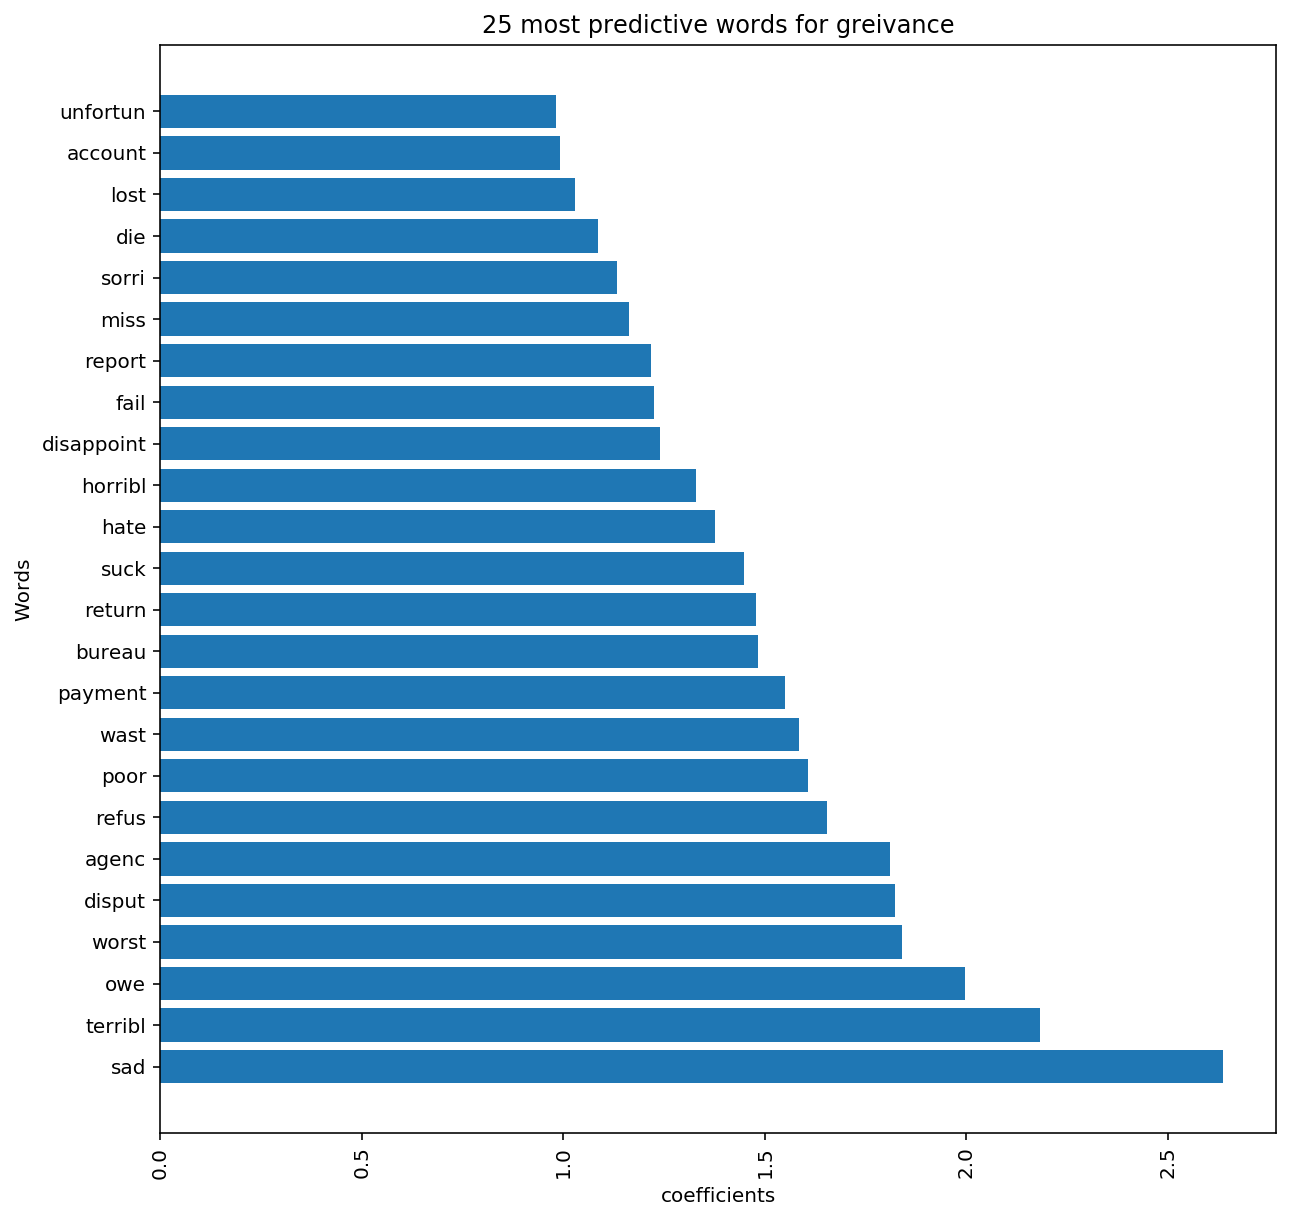

In [19]:
#Create a df for feature coefficients
coef_df = pd.DataFrame(data = log_reg.coef_, columns = X_train_transformed_df.columns, 
                       index = ['coef'])

#Top 25 words 
coef_df_top_25 = coef_df.sort_values(by ='coef', axis = 1, ascending = False).iloc[:,:24]

#Visualize top 25 words
plt.figure(figsize =(10,10))
plt.barh(coef_df_top_25.loc['coef'].index, coef_df_top_25.loc['coef'].values)
plt.xlabel("coefficients")
plt.xticks(rotation = 90)
plt.ylabel("Words")
plt.title('25 most predictive words for greivance')
plt.show()

Predictive words make a lot more sense now. However, there are still a few words like 'payment', 'bureau' related to financial products. These words however are not very specific financial products and do not need to be removed. In the following steps we will evaluate our model.

# Model Evaluation

In [20]:
#Verify loaded model
print(f"The accuracy of unoptimized Log reg model on train set is: {round(log_reg.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized Log reg model on test set is: {round(log_reg.score(X_test_transformed_df,y_test),2)}")




The accuracy of unoptimized Log reg model on train set is: 0.79
The accuracy of unoptimized Log reg model on test set is: 0.78


It must be noted that we have achieved good accuracies even with the unoptimized log reg model. However, rather than the overall accuracy, it is the **abiltiy of the model to calssify greivance that is more important**. In the next steps, we will look at some other metrics to further evaluate the model.

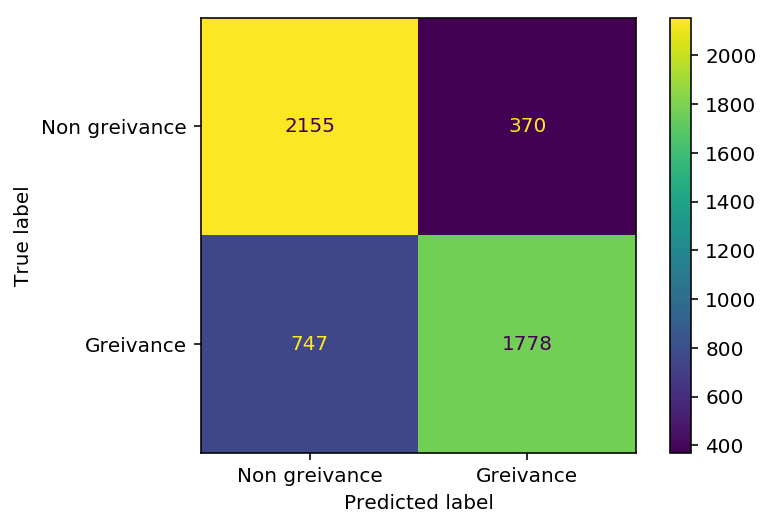

In [21]:
#Confusion matrix
y_pred_log_reg = log_reg.predict(X_test_transformed_df)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_log_reg)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

Just by looking at the confusion matrix, we can tell that model does a better job predicting `non greivance` where 377 values have been miscalssified i.e. approximately 15% as compared to `greivance` class where 758 values, approximatley 30%, have been misclassified. 

In [22]:
#Precision and recall
print(f"Precision score for unoptimized Log reg model is: {round(precision_score(y_test, y_pred_log_reg),2)}")
print(f"Recall score for unoptimized Log reg model is: {round(recall_score(y_test, y_pred_log_reg),2)}")


Precision score for unoptimized Log reg model is: 0.83
Recall score for unoptimized Log reg model is: 0.7


Precision score of 0.82 indicates that of all the positives (greivances) identified by the model, 82% actually are positive.<br> Recall score of 0.7 indicates that of all the actual positives, 70% have been identified by the model.<br>Although precision score is good, we must try to improve recall so that a higher proportion of actual positives (greivances) is identified by the model. Specifically for this model, **recall is more important becuase we want to predict most of the actual instances of greivances. Certain non greivances being missclassified in the process is of little importance.** However this trade off must not be huge beacuse too many non greivances classified as greivances will defeat the purpose of topic modelling where modelled topics will reflect general topics as well rather than community problems.

In [23]:
#F1 score
f1_score(y_test, y_pred_log_reg)


0.7609672587203082

# Decision Tree

In [24]:
#Fit decision tree
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train_transformed_df, y_train)


DecisionTreeClassifier()

In [25]:
#Verify accuracy
print(f"The accuracy of unoptimized DT model on train set is: {round(DT_model.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized DT model on test set is: {round(DT_model.score(X_test_transformed_df,y_test),2)}")


The accuracy of unoptimized DT model on train set is: 0.96
The accuracy of unoptimized DT model on test set is: 0.7


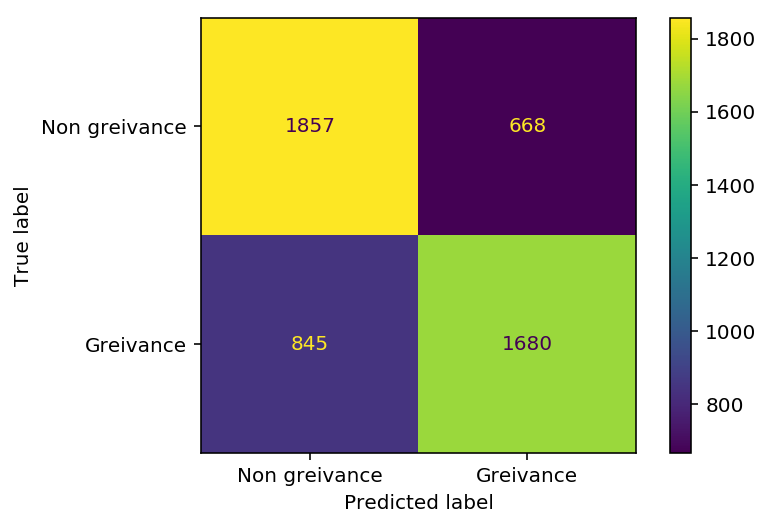

In [26]:
#Confusion matrix
y_pred_DT = DT_model.predict(X_test_transformed_df)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_DT)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

In [27]:
#Precision and recall
print(f"Precision score for unoptimized DT model is: {round(precision_score(y_test, y_pred_DT),2)}")
print(f"Recall score for unoptimized DT model is: {round(recall_score(y_test, y_pred_DT),2)}")

Precision score for unoptimized DT model is: 0.72
Recall score for unoptimized DT model is: 0.67


In [28]:
#F1 score
f1_score(y_test, y_pred_DT)

0.6895136466242561

# Random forest

In [29]:
#Fit random forest
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train_transformed_df, y_train)

RandomForestClassifier()

In [30]:
#Verify accuracy
print(f"The accuracy of unoptimized random forest on train set is: {round(rand_forest.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized random forest on test set is: {round(rand_forest.score(X_test_transformed_df,y_test),2)}")

The accuracy of unoptimized random forest on train set is: 0.96
The accuracy of unoptimized random forest on test set is: 0.78


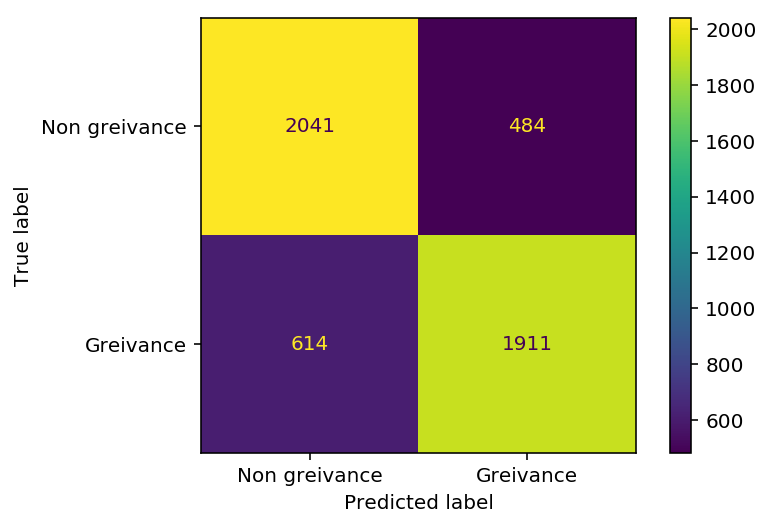

In [31]:
#Confusion matrix
y_pred_rf = rand_forest.predict(X_test_transformed_df)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_rf)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

In [32]:
#Precision and recall
print(f"Precision score for unoptimized random forest model is: {round(precision_score(y_test, y_pred_rf),2)}")
print(f"Recall score for unoptimized random forest model is: {round(recall_score(y_test, y_pred_rf),2)}")

Precision score for unoptimized random forest model is: 0.8
Recall score for unoptimized random forest model is: 0.76


In [33]:
#F1 score
f1_score(y_test, y_pred_rf)

0.7768292682926828

# Naive Bayes

In [34]:
#Fit Naive Bayes
NB = MultinomialNB()
NB.fit(X_train_transformed_df, y_train)

MultinomialNB()

In [35]:
#Verify accuracy
print(f"The accuracy of unoptimized DT model on train set is: {round(NB.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized DT model on test set is: {round(NB.score(X_test_transformed_df,y_test),2)}")


The accuracy of unoptimized DT model on train set is: 0.71
The accuracy of unoptimized DT model on test set is: 0.72


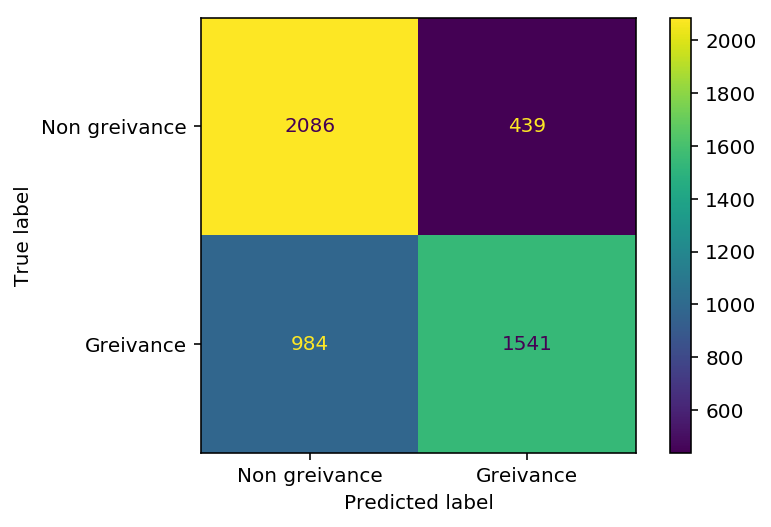

In [36]:
#Confusion matrix
y_pred_NB = NB.predict(X_test_transformed_df)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_NB)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

In [37]:
#Precision and recall
print(f"Precision score for unoptimized NB model is: {round(precision_score(y_test, y_pred_NB),2)}")
print(f"Recall score for unoptimized NB model is: {round(recall_score(y_test, y_pred_NB),2)}")

Precision score for unoptimized NB model is: 0.78
Recall score for unoptimized NB model is: 0.61


In [38]:
#F1 score
f1_score(y_test, y_pred_NB)

0.6841287458379579

# SVM Linear

In [39]:
#Instantiate
SVM_linear = LinearSVC()
#Fit
SVM_linear.fit(X_train_transformed_df, y_train)

C:\Users\Anuroop\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC()

In [40]:
#Verify accuracy
print(f"The accuracy of unoptimized Linear SVM model on train set is: {round(SVM_linear.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized Linear SVM model on test set is: {round(SVM_linear.score(X_test_transformed_df,y_test),2)}")

The accuracy of unoptimized Linear SVM model on train set is: 0.79
The accuracy of unoptimized Linear SVM model on test set is: 0.78


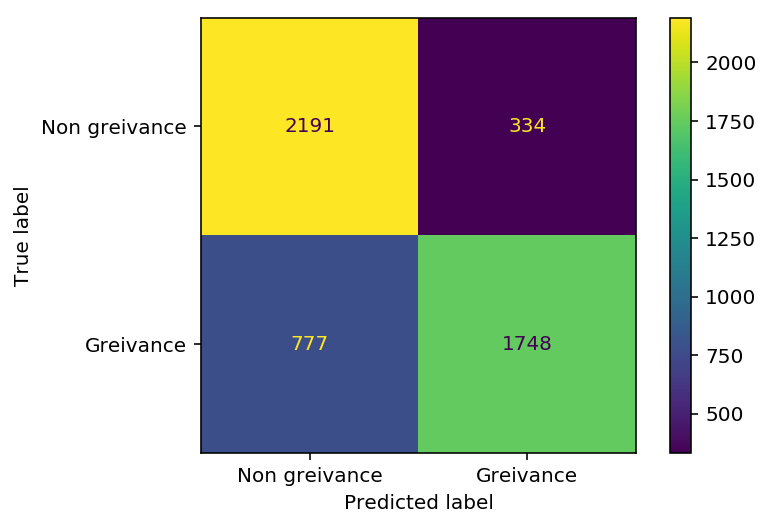

In [41]:
#Confusion matrix
y_pred_SVM_linear = SVM_linear.predict(X_test_transformed_df)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_SVM_linear)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

In [42]:
#Precision and recall
print(f"Precision score for unoptimized SVM linear model is: {round(precision_score(y_test, y_pred_SVM_linear),2)}")
print(f"Recall score for unoptimized SVM linear model is: {round(recall_score(y_test, y_pred_SVM_linear),2)}")

Precision score for unoptimized SVM linear model is: 0.84
Recall score for unoptimized SVM linear model is: 0.69


In [43]:
#F1 score
f1_score(y_test, y_pred_SVM_linear)

0.7588452355111786

# SVM rbf

In [44]:
#Fit
SVM_rbf = SVC(kernel='rbf')
SVM_rbf.fit(X_train_transformed_df, y_train)

SVC()

In [45]:
#Verify accuracy
print(f"The accuracy of unoptimized  SVM rbf model on train set is: {round(SVM_rbf.score(X_train_transformed_df,y_train),2)}")
print(f"The accuracy of unoptimized SVM rbf model on test set is: {round(SVM_rbf.score(X_test_transformed_df,y_test),2)}")

The accuracy of unoptimized  SVM rbf model on train set is: 0.82
The accuracy of unoptimized SVM rbf model on test set is: 0.77


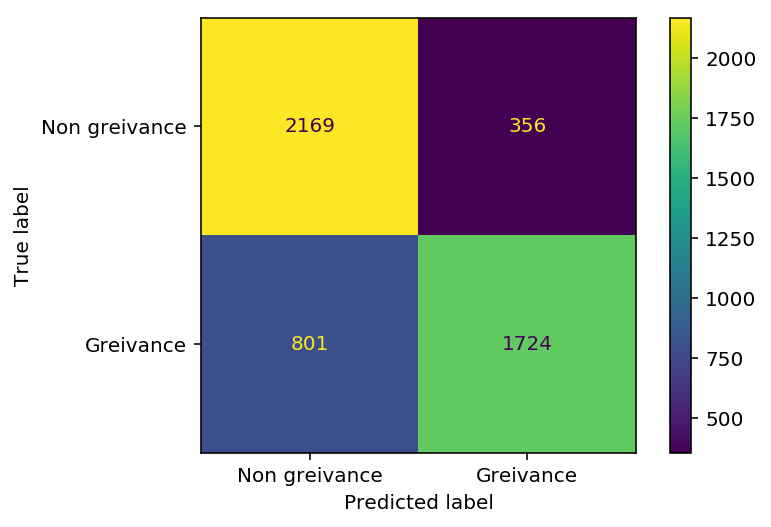

In [46]:
#Confusion matrix
y_pred_SVM_rbf = SVM_rbf.predict(X_test_transformed_df)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred_SVM_rbf)
cf_matrix

# Plot
ConfusionMatrixDisplay(cf_matrix, display_labels=['Non greivance','Greivance']).plot()
plt.show()

In [47]:
#Precision and recall
print(f"Precision score for unoptimized SVM rbf model is: {round(precision_score(y_test, y_pred_SVM_rbf),2)}")
print(f"Recall score for unoptimized SVM rbf model is: {round(recall_score(y_test, y_pred_SVM_rbf),2)}")

Precision score for unoptimized SVM rbf model is: 0.83
Recall score for unoptimized SVM rbf model is: 0.68


In [48]:
#F1 score
f1_score(y_test, y_pred_SVM_rbf)

0.7487513572204126

# Compare unoptimized models

In [49]:
##################################Create a metrics df
#Create  a dictionary where metrics will be the keys that hold a list of values
#for each model
metrics = {'Train Acc':[], 'Test Acc':[], 'Precision':[], 'Recall':[], 'f1':[]}

#model list
models = [log_reg, DT_model, rand_forest, NB, SVM_linear, SVM_rbf]

#pred variables list
y_preds = [y_pred_log_reg, y_pred_DT, y_pred_rf, y_pred_NB,
          y_pred_SVM_linear, y_pred_SVM_rbf] 

#Train and test acc
for model in models:
    metrics['Train Acc'].append(round(model.score(X_train_transformed_df, y_train),2))
    metrics['Test Acc'].append(round(model.score(X_test_transformed_df, y_test),2))
    
#Precison, recall and f1
for y_pred in y_preds:
    metrics['Precision'].append(round(precision_score(y_test, y_pred),2))
    metrics['Recall'].append(round(recall_score(y_test, y_pred),2))
    metrics['f1'].append(round(f1_score(y_test, y_pred),2))



In [50]:
#Verify
metrics

{'Train Acc': [0.79, 0.96, 0.96, 0.71, 0.79, 0.82],
 'Test Acc': [0.78, 0.7, 0.78, 0.72, 0.78, 0.77],
 'Precision': [0.83, 0.72, 0.8, 0.78, 0.84, 0.83],
 'Recall': [0.7, 0.67, 0.76, 0.61, 0.69, 0.68],
 'f1': [0.76, 0.69, 0.78, 0.68, 0.76, 0.75]}

In [54]:
#Create df
metrics_df = pd.DataFrame(data = metrics, index = ['log_reg', 'DT', 'rand_forest' ,'NB', 'SVM_linear', 'SVM_rbf' ])
metrics_df.head()

,Train Acc,Test Acc,Precision,Recall,f1
log_reg,0.79,0.78,0.83,0.70,0.76
DT,0.96,0.70,0.72,0.67,0.69
rand_forest,0.96,0.78,0.80,0.76,0.78
NB,0.71,0.72,0.78,0.61,0.68
SVM_linear,0.79,0.78,0.84,0.69,0.76


In [ ]:
metrics_df.head()

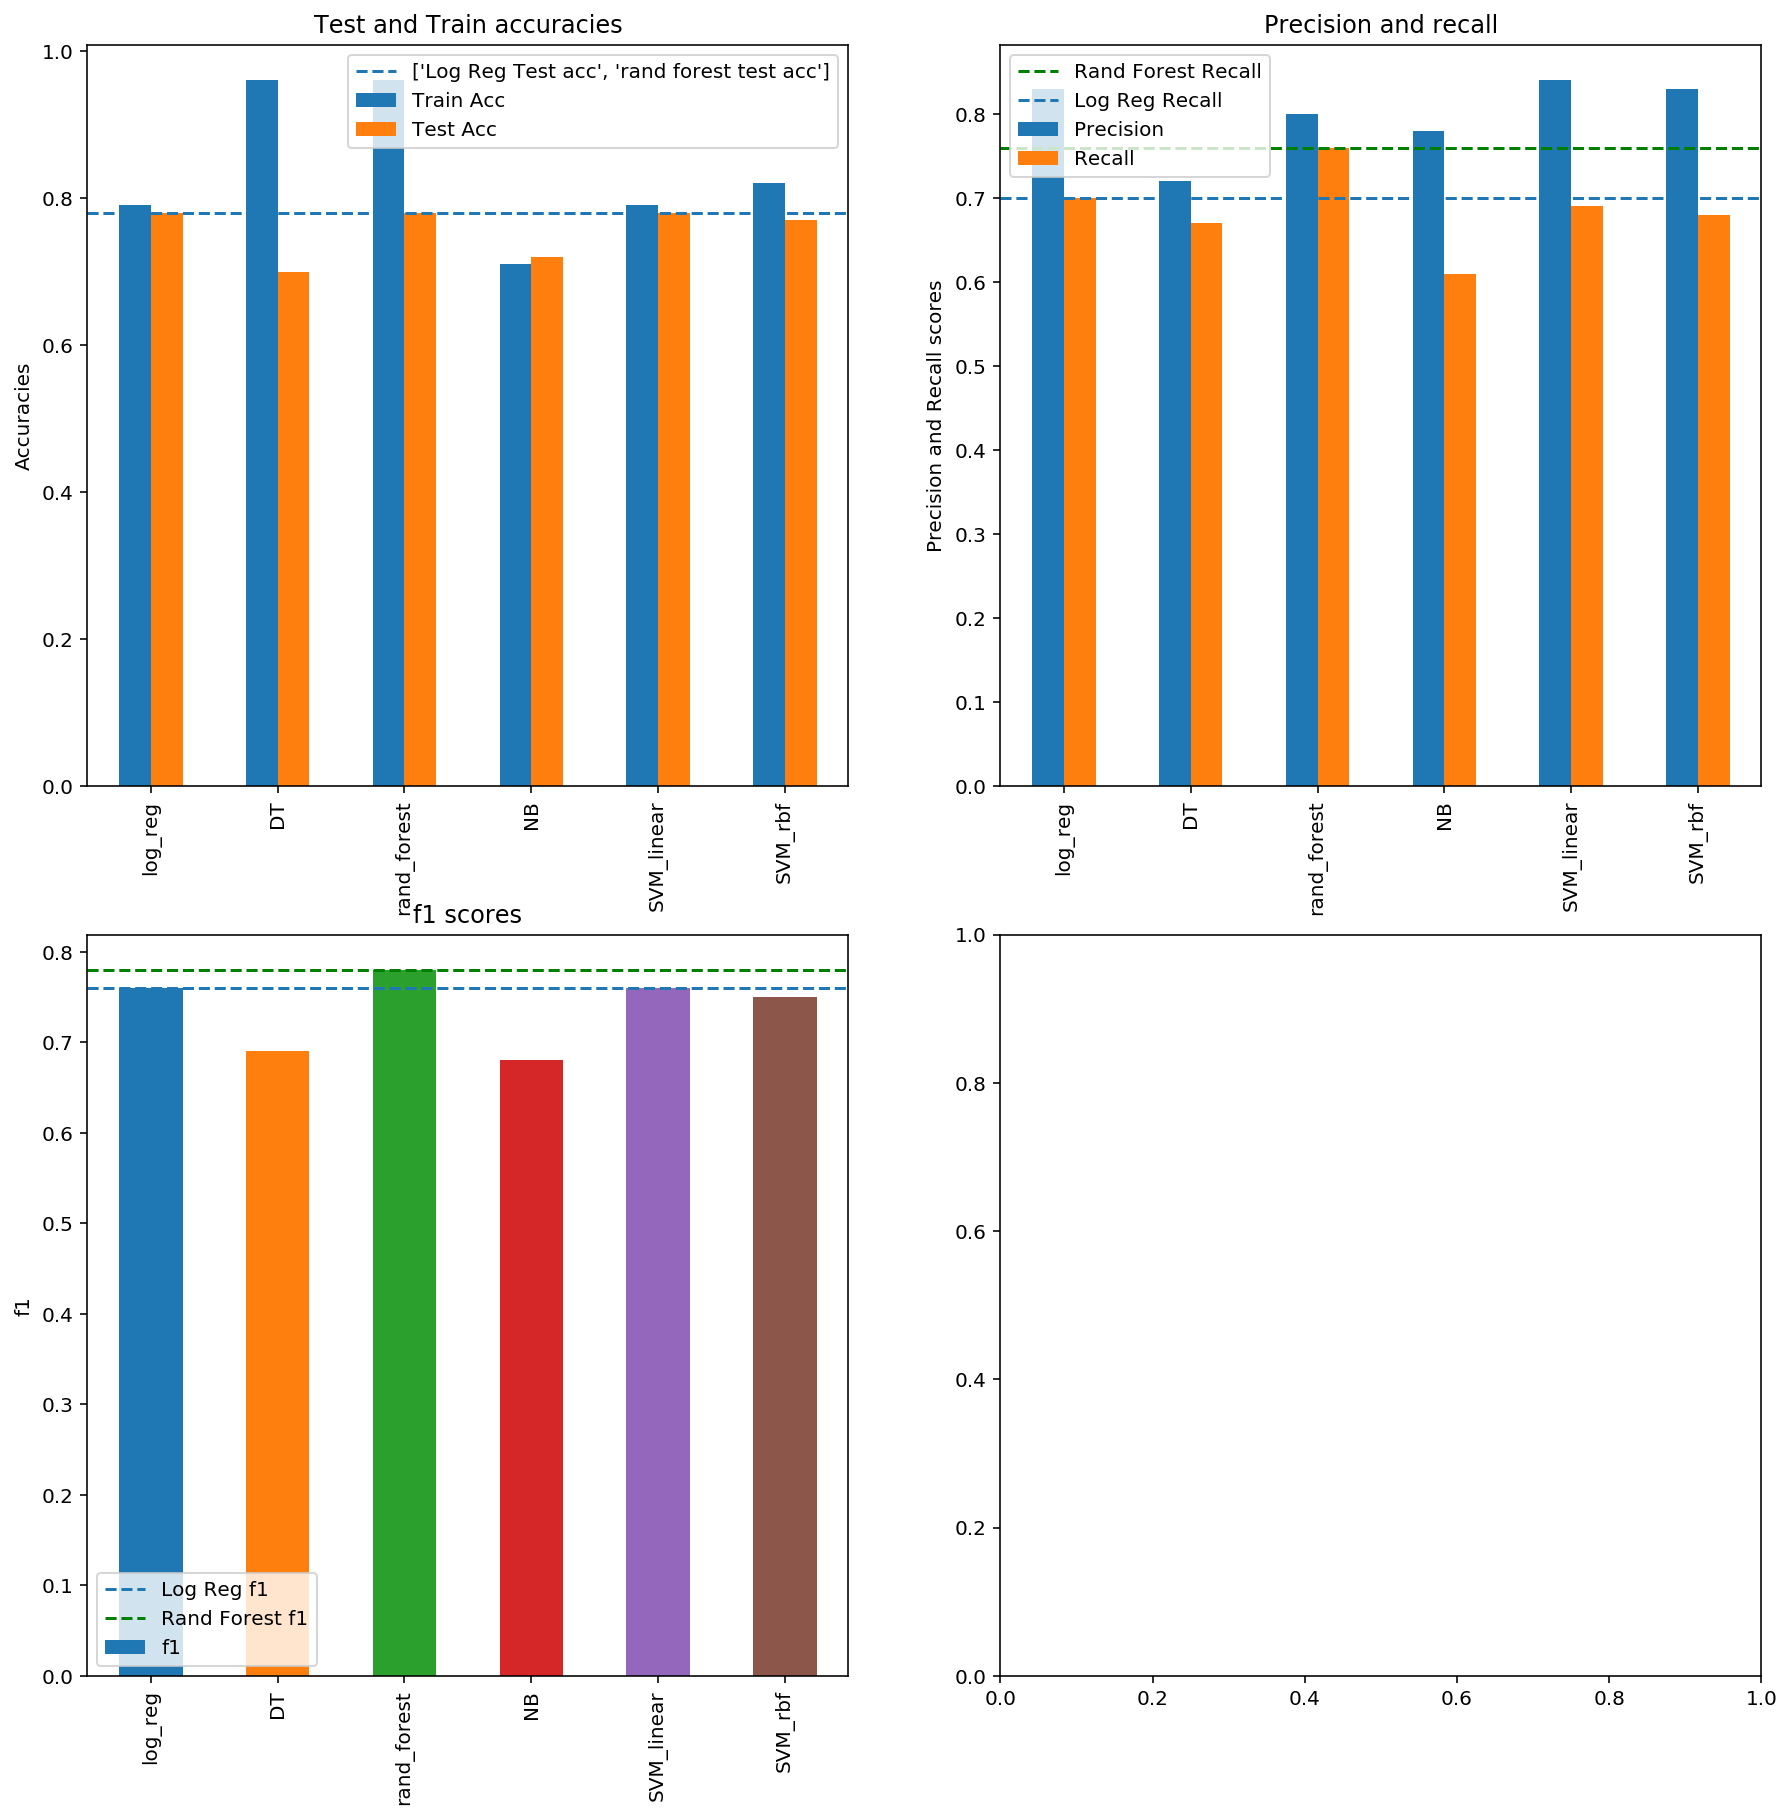

In [59]:
#Visualize metrics
fig, axes = plt.subplots(figsize = (15,15),nrows=2, ncols=2)

#subplot 1 - test and train acc
metrics_df.iloc[:,:2].plot.bar(ax = axes[0,0], title = "Test and Train accuracies")
axes[0,0].axhline( y = 0.78, xmin = 0, xmax =1 , linestyle = '--',
                 label = ['Log Reg Test acc', 'rand forest test acc'])
axes[0,0].set_ylabel('Accuracies')
axes[0,0].legend()

#subplot 2 - precision and recall
metrics_df.iloc[:,2:4].plot.bar(ax = axes[0,1], title = 'Precision and recall')
axes[0,1].axhline( y = 0.76, xmin = 0, xmax =1 , linestyle = '--',
                 label = 'Rand Forest Recall', color ='green')
axes[0,1].axhline( y = 0.7, xmin = 0, xmax =1 , linestyle = '--',
                 label = 'Log Reg Recall')
axes[0,1].set_ylabel('Precision and Recall scores')
axes[0,1].legend()

#subplot 3 - f1
metrics_df['f1'].plot.bar(ax = axes[1,0], title ='f1 scores')
axes[1,0].axhline( y = 0.76, xmin = 0, xmax =1 , linestyle = '--',
                 label = 'Log Reg f1')
axes[1,0].axhline( y = 0.78, xmin = 0, xmax =1 , linestyle = '--',
                 label = 'Rand Forest f1', color ='green')
axes[1,0].set_ylabel('f1')
axes[1,0].legend()




**2 models that stands out here, from visualiztion of unoptimized model metrics, are Logistic Regression and Random Forest**. It can be seen in `Test and Train accuracies` that the accuracy of Logistic Regression, random forest and SVM Linear are the same, blue dashed line. However when we look at `precision and recall`, random forest has the highest recall followed by Logistic Regression and SVM linear. As discussed above, recall is a higher priority for our model than precision. Random forest also stands out in `f1 score`. Hence we will **tune hyperparameters** for our **Random forest** since it has demonstrated best performance and  also **Logistic Regression model** which being the simplest linear model has yet performed really well. Although SVM linear performed well too, it's performance is very similar to logistic regression and can be ignored. SVM rbf provides a similar performance as  SVM Linear and can be ignored as there is no point using more expensive rbf kernel when similar accuracies can be achieved with linear model. We can also ignore NB as it does not really stand out in this comparison. In the next steps we will optimize Logistic regression and Random Forest via gridsearch to finalize classifier.

# Save models via joblib

In [60]:
#Save vectorizer
joblib.dump(bagofwords, 'bagofwords_exp_contractions_rm_prdcts_50K.pkl')

['bagofwords_exp_contractions_rm_prdcts_50K.pkl']

In [61]:
#Load saved models
bagofwords= joblib.load('bagofwords_exp_contractions_rm_prdcts_50K.pkl')

In [62]:
#Verify loaded bag of words fit
#transform test data and compare with original 
X_test_transformed_verification = bagofwords.transform(X_test)
#1st 20 elements
display(X_test_transformed_verification.toarray()[0][:19])
display(X_test_transformed.toarray()[0][:19])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=int64)